## Please find the logs at https://drive.google.com/drive/folders/1hgso21P24CDMNSOI7ZyTvOcMLBCTg39D?usp=sharing

### Results at the bottom

In [1]:
import tensorflow as tf #tensorflow 1.x
#tf.enable_eager_execution() #enable it for reading tensorboard events, else disable
import numpy as np
from mlxtend.data import loadlocal_mnist
from tqdm import tqdm
import sys
from pathlib import Path
import os
from tensorflow.core.util.event_pb2 import Event
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorflow\

C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\manji\anaconda3\envs\tf_gpu1\lib\site

In [2]:
class Softmax:
    def __init__(self, inp_len, out_len, dropout = False, normalize = False):
        
        self.inp_len = inp_len
        self.out_len = out_len
        self.X = tf.placeholder(tf.float32, shape = [None, self.inp_len])
        self.Y = tf.placeholder(tf.float32, shape = [None, self.out_len])
        self.weights = tf.Variable(tf.glorot_uniform_initializer()((self.inp_len, self.out_len)))
        self.biases = tf.Variable(tf.glorot_uniform_initializer()((self.out_len,)))
        self.global_step = tf.Variable(0, trainable=False)
        self.learning_rate_start = 0.001
        self.learning_rate = tf.train.exponential_decay(self.learning_rate_start, self.global_step, \
                                                        100, 0.96, staircase=True)
        self.dropout = dropout
        self.normalize = normalize
        self.dropout_rate = 0.5

    def Regression(self):
        layer = tf.add(tf.matmul(self.X, self.weights), self.biases)
        if self.normalize:
            layer = tf.layers.BatchNormalization()(layer)
        if self.dropout:
            layer = tf.layers.dropout(layer, self.dropout_rate)

        return layer

    def LossFunction(self):
        #Cross entropy
        pred = self.Regression()
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.Y, logits = pred)
        loss = tf.reduce_mean(loss)
        return loss

    def TrainModel(self):
        
        loss = self.LossFunction()
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        learning_operation = optimizer.minimize(loss, global_step = self.global_step)
        return learning_operation

    def Accuracy(self):
        
        pred = self.Regression()
        pred = tf.nn.softmax(pred)
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))
        return accuracy


In [3]:
class MLP:
    def __init__(self, inp_len, out_len, dropout = False, normalize = False):
        
        self.inp_len = inp_len
        self.out_len = out_len
        self.X = tf.placeholder(tf.float32, shape = [None, self.inp_len])
        self.Y = tf.placeholder(tf.float32, shape = [None, self.out_len])
        self.n_layer_1 = 512
        self.n_layer_2 = 256
        # two hidden layers variables
        self.weights = {
                        'w1' : tf.Variable(tf.glorot_uniform_initializer()((self.inp_len, self.n_layer_1))),
                        'w2' : tf.Variable(tf.glorot_uniform_initializer()((self.n_layer_1, self.n_layer_2))),
                        'w3' : tf.Variable(tf.glorot_uniform_initializer()((self.n_layer_2, self.out_len)))
                        }
        self.biases = {
                        'b1' : tf.Variable(tf.glorot_uniform_initializer()((self.n_layer_1,))),
                        'b2' : tf.Variable(tf.glorot_uniform_initializer()((self.n_layer_2,))),
                        'b3' : tf.Variable(tf.glorot_uniform_initializer()((self.out_len,)))
                        }
        self.global_step = tf.Variable(0, trainable=False)
        self.learning_rate_start = 0.001
        self.learning_rate = tf.train.exponential_decay(self.learning_rate_start, self.global_step, \
                                                        100, 0.96, staircase=True)
        self.dropout = dropout
        self.normalize = normalize
        self.dropout_rate = 0.5

    def MultiLayers(self):
        
        layer_one = tf.add(tf.matmul(self.X, self.weights['w1']), self.biases['b1'])
        if self.normalize:
            layer_one = tf.layers.BatchNormalization()(layer_one)
        if self.dropout:
            layer_one = tf.layers.dropout(layer_one, self.dropout_rate)
        layer_one = tf.nn.relu(layer_one)

        layer_two = tf.add(tf.matmul(layer_one, self.weights['w2']), self.biases['b2'])
        if self.normalize:
            layer_two = tf.layers.BatchNormalization()(layer_two)
        if self.dropout:
            layer_two = tf.layers.dropout(layer_two, self.dropout_rate)
        layer_two = tf.nn.relu(layer_two)        

        layer_three = tf.add(tf.matmul(layer_two, self.weights['w3']), self.biases['b3'])
        if self.dropout:
            layer_three = tf.layers.dropout(layer_three, self.dropout_rate)        

        return layer_three

    def LossFunction(self):
        
        pred = self.MultiLayers()
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.Y, logits = pred)
        loss = tf.reduce_mean(loss)
        return loss

    def TrainModel(self):
        
        loss = self.LossFunction()
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        learning_operation = optimizer.minimize(loss, global_step = self.global_step)
        return learning_operation

    def Accuracy(self):
        
        pred = self.MultiLayers()
        pred = tf.nn.softmax(pred)
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))
        return accuracy



In [4]:
class CNN:
    def __init__(self, inp_len, out_len, dropout = False, normalize = False):
        
        self.w, self.h = inp_len
        self.out_len = out_len
        self.X = tf.placeholder(tf.float32, shape = [None, self.w, self.h, 1])
        self.Y = tf.placeholder(tf.float32, shape = [None, self.out_len])
        self.input_channel = 1
        self.n_feature_1 = 32
        self.n_feature_2 = 64
        self.n_feature_3 = 64
        self.n_layers_1 = 4 * 4 * 64
        # define convolutional kernels and maxpool kernels
        self.kernels = {
                        'k1' : tf.Variable(tf.glorot_uniform_initializer()([3, 3, self.input_channel, self.n_feature_1])),
                        'k2' : [1, 2, 2, 1],
                        'k3' : tf.Variable(tf.glorot_uniform_initializer()([3, 3, self.n_feature_1, self.n_feature_2])),
                        'k4' : [1, 2, 2, 1],
                        'k5' : tf.Variable(tf.glorot_uniform_initializer()([3, 3, self.n_feature_2, self.n_feature_3])),
                        }
        # define pooling methods
        self.padding = {
                        'p1' : 'VALID',
                        'p2' : 'SAME',
                        'p3' : 'VALID',
                        'p4' : 'SAME',
                        'p5' : 'VALID',
                        }
        # define strides
        self.strides = {
                        's1' : [1, 1, 1, 1],
                        's2' : [1, 2, 2, 1],
                        's3' : [1, 1, 1, 1],
                        's4' : [1, 2, 2, 1],
                        's5' : [1, 1, 1, 1],
                        }
        # define variables of the last layer
        self.weights = {
                        'w6' : tf.Variable(tf.glorot_uniform_initializer()([self.n_layers_1, self.out_len]))
                        }
        self.biases = {
                        'b6' : tf.Variable(tf.glorot_uniform_initializer()((self.out_len,)))
                        }
        self.global_step = tf.Variable(0, trainable=False)
        self.learning_rate_start = 0.001
        self.learning_rate = tf.train.exponential_decay(self.learning_rate_start, self.global_step, \
                                                        100, 0.96, staircase=True)
        self.dropout = dropout
        self.normalize = normalize
        self.dropout_rate = 0.5

    def ConvolutionalLayer(self, input_data, kernel, strides, padding):
        
        layer = tf.nn.conv2d(input_data, kernel, strides = strides, padding = padding)
        if self.normalize:
            layer = tf.layers.BatchNormalization()(layer)
        layer = tf.nn.relu(layer)
        return layer

    def MaxPool(self, input_data, ksize, strides, padding):
        
        layer = tf.nn.max_pool(input_data, ksize, strides = strides, padding = padding)
        return layer

    def LastLayer(self, input_data, weights, biases, if_relu = True):
        
        input_data = tf.reshape(input_data, [tf.shape(input_data)[0], -1])
        layer = tf.add(tf.matmul(input_data, weights), biases)
        if self.dropout:
            layer = tf.layers.dropout(layer, self.dropout_rate)
        if if_relu:
            layer = tf.nn.relu(layer)
        return layer

    def ConvolutionNet(self):
        
        layer = self.ConvolutionalLayer(self.X, self.kernels['k1'], self.strides['s1'], self.padding['p1'])
        layer = self.MaxPool(layer, self.kernels['k2'], self.strides['s2'], self.padding['p2'])
        layer = self.ConvolutionalLayer(layer, self.kernels['k3'], self.strides['s3'], self.padding['p3'])
        layer = self.MaxPool(layer, self.kernels['k4'], self.strides['s4'], self.padding['p4'])
        layer = self.ConvolutionalLayer(layer, self.kernels['k5'], self.strides['s5'], self.padding['p5'])

        layer = self.LastLayer(layer, self.weights['w6'], self.biases['b6'], if_relu = False)
        return layer

    def LossFunction(self):
        
        pred = self.ConvolutionNet()
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.Y, logits = pred)
        loss = tf.reduce_mean(loss)
        return loss

    def TrainModel(self):
        
        loss = self.LossFunction()
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        learning_operation = optimizer.minimize(loss, global_step = self.global_step)
        return learning_operation

    def Accuracy(self):
        
        pred = self.ConvolutionNet()
        pred = tf.nn.softmax(pred)
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, dtype = tf.float32))
        return accuracy


In [5]:
def label_trans(labels, num_class):
    
    hm_labels = len(labels)
    label_onehot = np.zeros((hm_labels, num_class), dtype = np.float32)
    for i in range(hm_labels):
        current_class = labels[i]
        label_onehot[i, current_class] = 1.
    return label_onehot

def load_data(data_path, mode):
    
    # load
    X_train, Y_train_original = loadlocal_mnist(
            images_path=data_path + "train-images-idx3-ubyte", 
            labels_path=data_path + "train-labels-idx1-ubyte")
    X_test, Y_test_original = loadlocal_mnist(
            images_path=data_path + "t10k-images-idx3-ubyte", 
            labels_path=data_path + "t10k-labels-idx1-ubyte")
    
    # convert
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # CNN needs reshaping
    if mode == "CNN":
        X_train = np.expand_dims(X_train.reshape((-1, 28, 28)), axis = -1)
        X_test = np.expand_dims(X_test.reshape((-1, 28, 28)), axis = -1)
        
    all_classes = np.unique(Y_train_original)
    num_class = len(all_classes)
    
    if mode == "CNN":
        num_input = (28, 28)
    else:
        num_input = X_train.shape[1]    

    # transfer label format
    Y_train = label_trans(Y_train_original, num_class)
    Y_test = label_trans(Y_test_original, num_class)
    return X_train, Y_train, X_test, Y_test, num_input, num_class

def FolderName(mode, dropout, normalize):
    
    original_name = '/' + mode
    if dropout:
        original_name += '_dropout'
    if normalize:
        original_name += '_normalize'
    return original_name

In [6]:
def worker(mode,dropout,normalize):

    # basical settings
    epoches = 20
    batch_size = 500
    Mnist_local_path = "mnist/"


    X_train, Y_train, X_test, Y_test, inp_len, out_len = load_data(Mnist_local_path, mode)

    # training parameter
    hm_batches_train = len(X_train) // batch_size
    hm_batches_test = len(X_test) // batch_size

    if mode == "softmax":
        model = Softmax(inp_len, out_len, dropout, normalize)
    elif mode == "MLP":
        model = MLP(inp_len, out_len, dropout, normalize)
    elif mode == "CNN":
        model = CNN(inp_len, out_len, dropout, normalize)
    else:
        raise ValueError("Wrong Mode Input, please doublecheck it.")

    loss = model.LossFunction()
    accuracy = model.Accuracy()
    
    loss_graph_name = "loss"
    acc_graph_name = "accuracy"
    summary_loss = tf.summary.scalar(loss_graph_name, loss)
    streaming_accuracy, streaming_accuracy_update = tf.contrib.metrics.streaming_mean(accuracy)
    summary_accuracy = tf.summary.scalar(acc_graph_name, streaming_accuracy)

    train = model.TrainModel()

    # initialization
    init = tf.global_variables_initializer()

    # GPU settings
    gpu_options = tf.GPUOptions(allow_growth=True)

    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        summaries_train = 'logs/train/'
        summaries_test = 'logs/test/'
        folder_name = FolderName(mode, dropout, normalize)
        train_writer = tf.summary.FileWriter(summaries_train + folder_name, sess.graph)
        test_writer = tf.summary.FileWriter(summaries_test + folder_name, sess.graph)
        summary_acc = tf.Summary()
        sess.run(init)
        for each_epoch in tqdm(range(epoches)):
            for each_batch_train in range(hm_batches_train):
                X_train_batch = X_train[each_batch_train*batch_size: (each_batch_train+1)*batch_size]
                Y_train_batch = Y_train[each_batch_train*batch_size: (each_batch_train+1)*batch_size]

                _, loss_val, summary_l, steps = sess.run([train, loss, summary_loss, model.global_step], \
                                                                    feed_dict = {model.X : X_train_batch, \
                                                                                model.Y : Y_train_batch})

                train_writer.add_summary(summary_l, steps)
                
                sess.run(tf.local_variables_initializer())
                for each_batch_test in range(hm_batches_test):
                    X_test_batch = X_test[each_batch_test*batch_size: (each_batch_test+1)*batch_size]
                    Y_test_batch = Y_test[each_batch_test*batch_size: (each_batch_test+1)*batch_size]
                    sess.run([streaming_accuracy_update], feed_dict = {model.X : X_test_batch, \
                                                            model.Y : Y_test_batch})

                summary_a = sess.run(summary_accuracy)
                test_writer.add_summary(summary_a, steps)

In [7]:
worker("softmax",False,False)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.mean








100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:34<00:00,  4.71s/it]


In [8]:
worker("softmax",True,False)

Instructions for updating:
Use keras.layers.dropout instead.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:31<00:00, 10.57s/it]


In [9]:
worker("softmax",False,True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [05:44<00:00, 17.24s/it]


In [7]:
worker("MLP",False,False)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please switch to tf.metrics.mean








100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:52<00:00,  5.64s/it]


In [8]:
worker("MLP",True,False)

Instructions for updating:
Use keras.layers.dropout instead.


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:44<00:00, 11.22s/it]


In [9]:
worker("MLP",False,True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [06:09<00:00, 18.47s/it]


In [13]:
worker("CNN",False,False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [20:40<00:00, 62.04s/it]


In [14]:
worker("CNN",True,False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [24:40<00:00, 74.04s/it]


In [15]:
worker("CNN",False,True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [30:50<00:00, 92.52s/it]


In [3]:
def is_interesting_tag(tag):
    if 'val' in tag or 'train' in tag:
        return True
    else:
        return False

def parse_events_file(path: str) -> pd.DataFrame:
    metrics = defaultdict(list)
    input_dir = Path(path)
    for ev_file in input_dir.glob('**/*.tfevents*'):
        for rec in tf.data.TFRecordDataset([str(ev_file)]):
                # Read event
                ev = Event()
                ev.MergeFromString(rec.numpy())
                # Check if it is a summary
                if ev.summary:
                    # Iterate summary values
                    for v in ev.summary.value:
                        #if isinstance(v.simple_value, float) and is_interesting_tag(v.tag):
                        if isinstance(v.simple_value, float):
                            metrics[v.tag].append(v.simple_value)

                        #print(v.simple_value)
        metrics_df = pd.DataFrame({k: v for k,v in metrics.items() if len(v) > 1})
        return metrics_df

metrics_df = parse_events_file("try/")

## Classifier Comparison on default setting (i.e. No dropout and No batch-normalisation)

In [16]:
%matplotlib notebook

In [4]:
sft = parse_events_file("logs/test/softmax/")
mlp = parse_events_file("logs/test/MLP/")
cnn = parse_events_file("logs/test/CNN/")

<IPython.core.display.Javascript object>


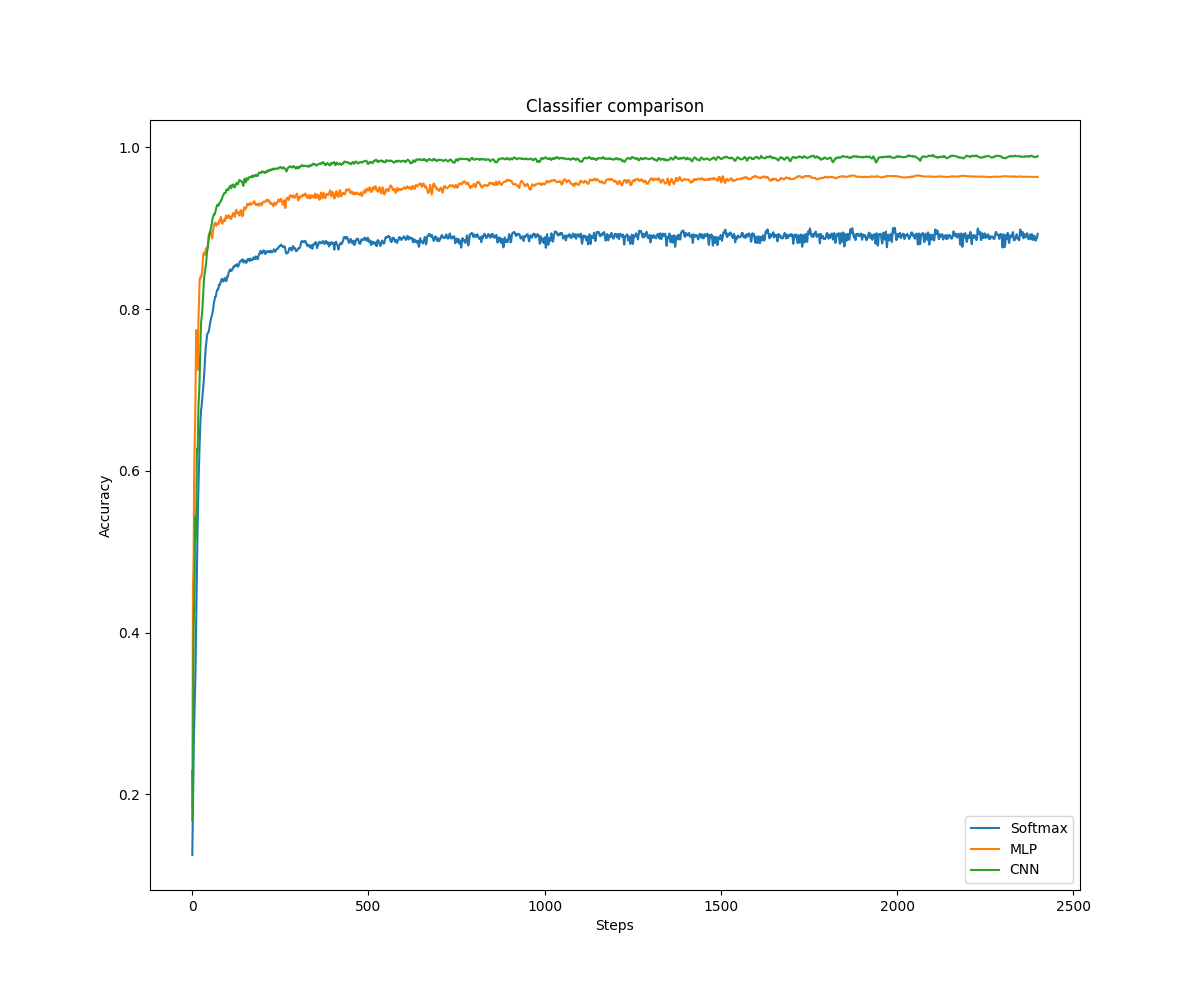

In [22]:
x = [y for y in range(len(sft))]
plt.figure(figsize=(12,10))
plt.plot(x,sft["accuracy"],label='Softmax')
plt.plot(x,mlp["accuracy"],label='MLP')
plt.plot(x,cnn["accuracy_6"],label='CNN')
plt.title("Classifier comparison")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [8]:
sft_loss = parse_events_file("logs/train/softmax/")
mlp_loss = parse_events_file("logs/train/MLP/")
cnn_loss = parse_events_file("logs/train/CNN/")

<IPython.core.display.Javascript object>


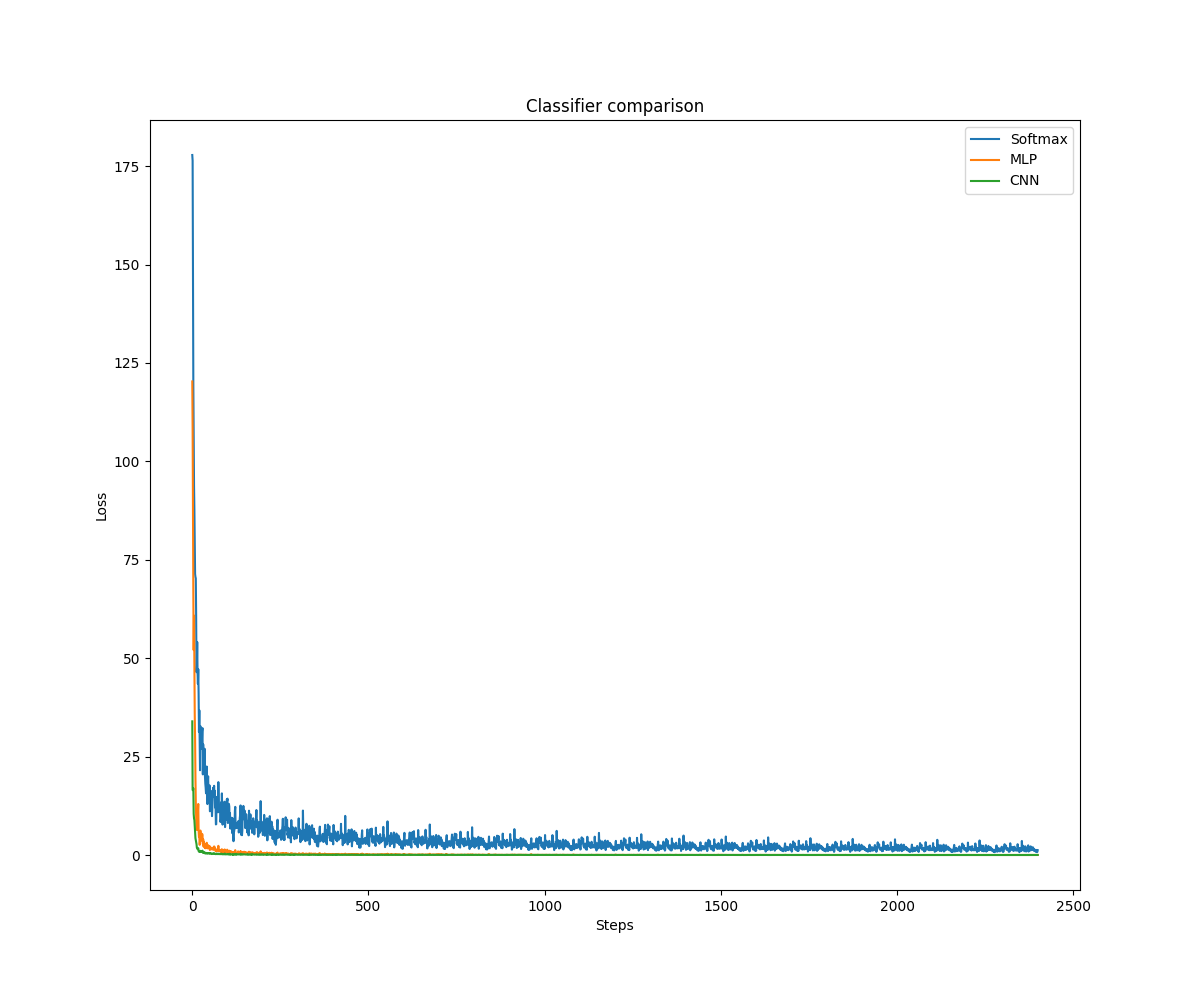

In [23]:
plt.figure(figsize=(12,10))
plt.plot(x,sft_loss["loss"],label='Softmax')
plt.plot(x,mlp_loss["loss"],label='MLP')
plt.plot(x,cnn_loss["loss_6"],label='CNN')
plt.title("Classifier comparison")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Effects of Dropout and Batch Normalization on a classifier

## 1. Softmax

In [31]:
sft_drop_acc = parse_events_file("logs/test/softmax_dropout/")
sft_norm_acc = parse_events_file("logs/test/softmax_normalize/")

<IPython.core.display.Javascript object>


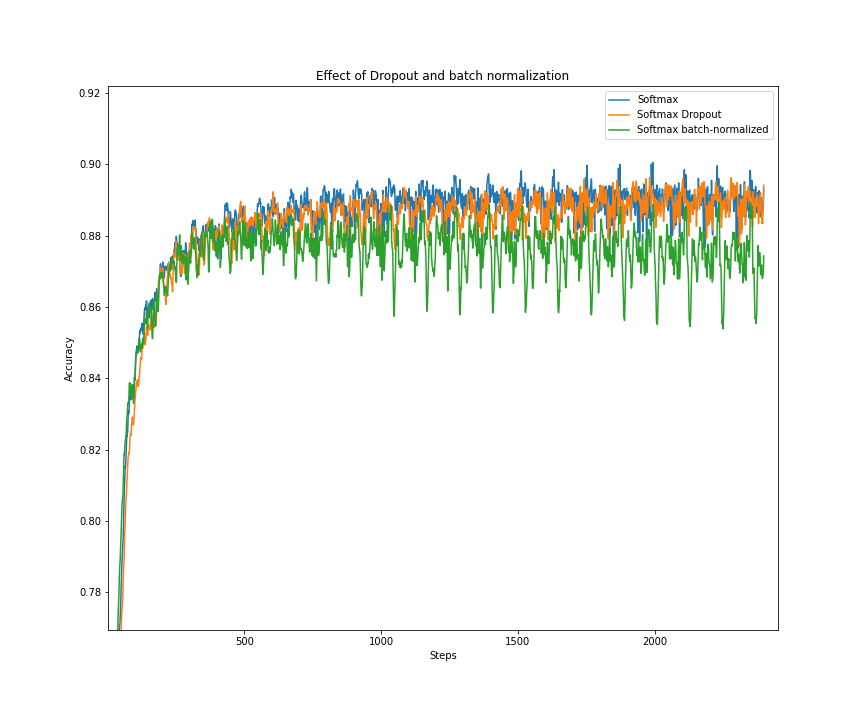

In [50]:
plt.figure(figsize=(12,10))
plt.plot(x,sft["accuracy"],label='Softmax')
plt.plot(x,sft_drop_acc["accuracy_1"],label='Softmax Dropout')
plt.plot(x,sft_norm_acc["accuracy_2"],label='Softmax batch-normalized')
plt.title("Effect of Dropout and batch normalization")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [34]:
sft_drop_loss = parse_events_file("logs/train/softmax_dropout/")
sft_norm_loss = parse_events_file("logs/train/softmax_normalize/")

<IPython.core.display.Javascript object>


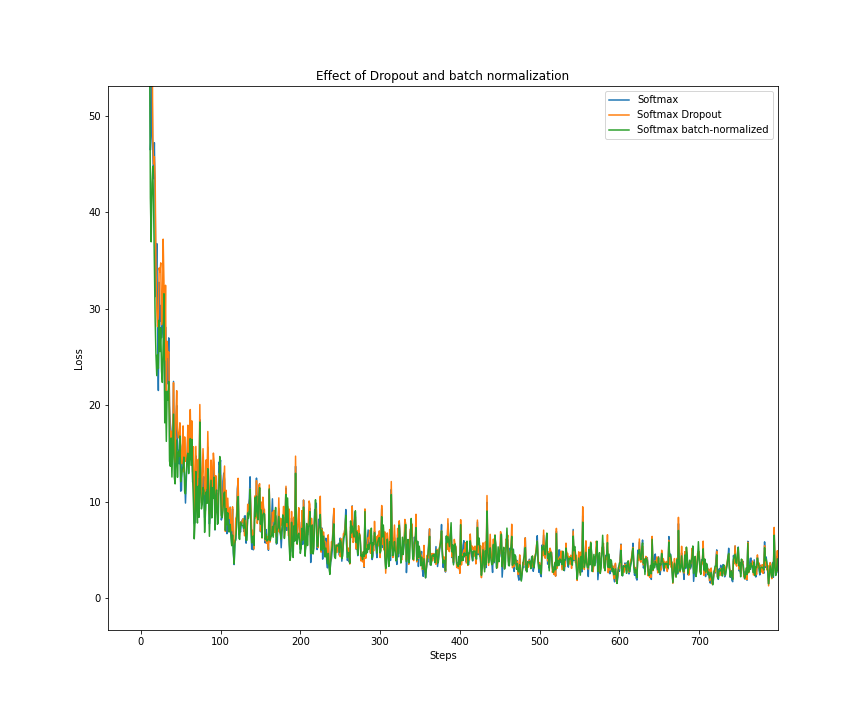

In [51]:
plt.figure(figsize=(12,10))
plt.plot(x,sft_loss["loss"],label='Softmax')
plt.plot(x,sft_drop_loss["loss_1"],label='Softmax Dropout')
plt.plot(x,sft_norm_loss["loss_2"],label='Softmax batch-normalized')
plt.title("Effect of Dropout and batch normalization")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 2. MLP

In [10]:
mlp_drop_acc = parse_events_file("logs/test/MLP_dropout/")
mlp_drop_loss = parse_events_file("logs/train/MLP_dropout/")
mlp_norm_acc = parse_events_file("logs/test/MLP_normalize/")
mlp_norm_loss = parse_events_file("logs/train/MLP_normalize/")

<IPython.core.display.Javascript object>


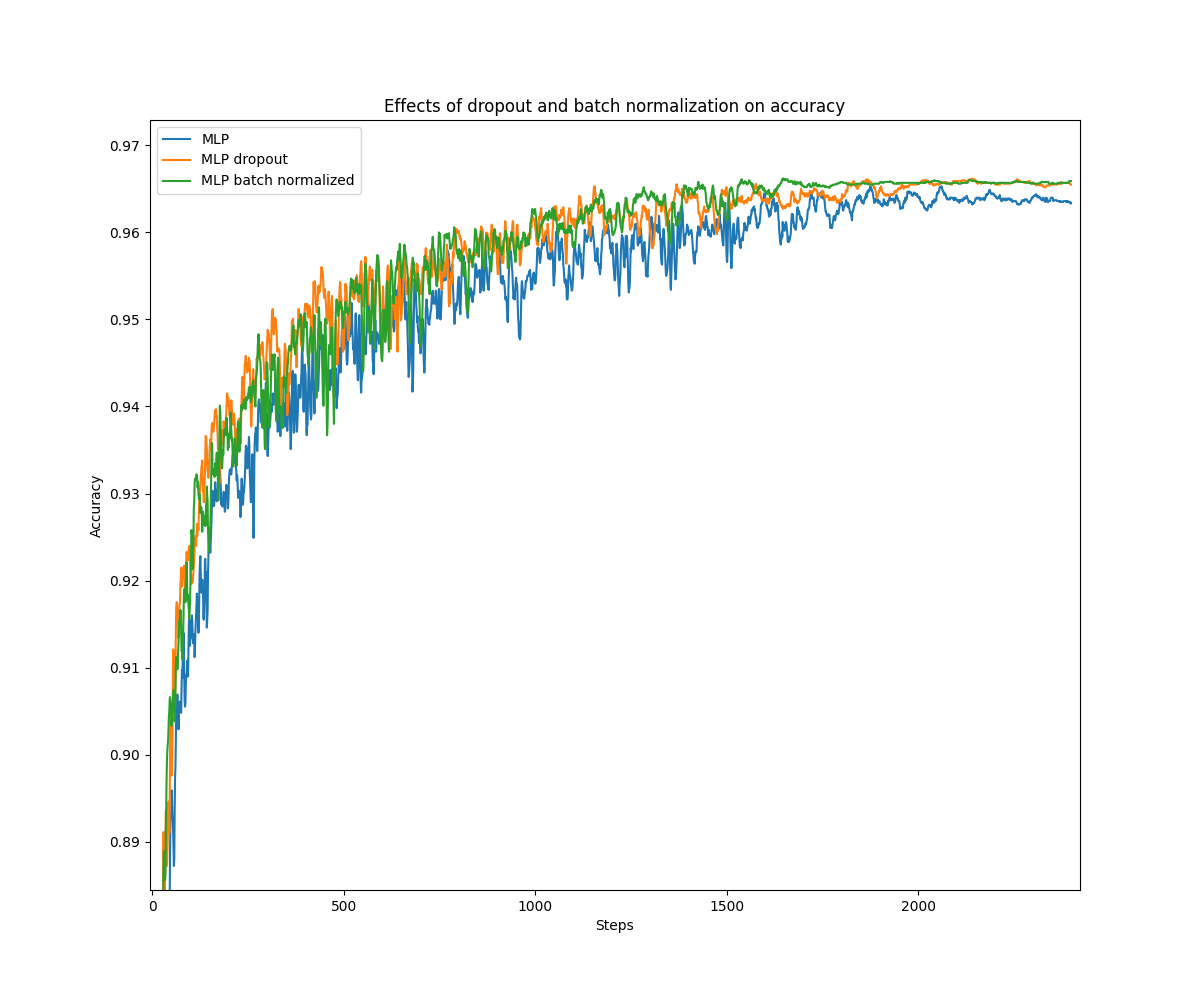

In [20]:
plt.figure(figsize=(12,10))
plt.plot(x,mlp["accuracy"],label='MLP')
plt.plot(x,mlp_drop_acc["accuracy_1"],label='MLP dropout')
plt.plot(x,mlp_norm_acc["accuracy_2"],label='MLP batch normalized')
plt.title("Effects of dropout and batch normalization on accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


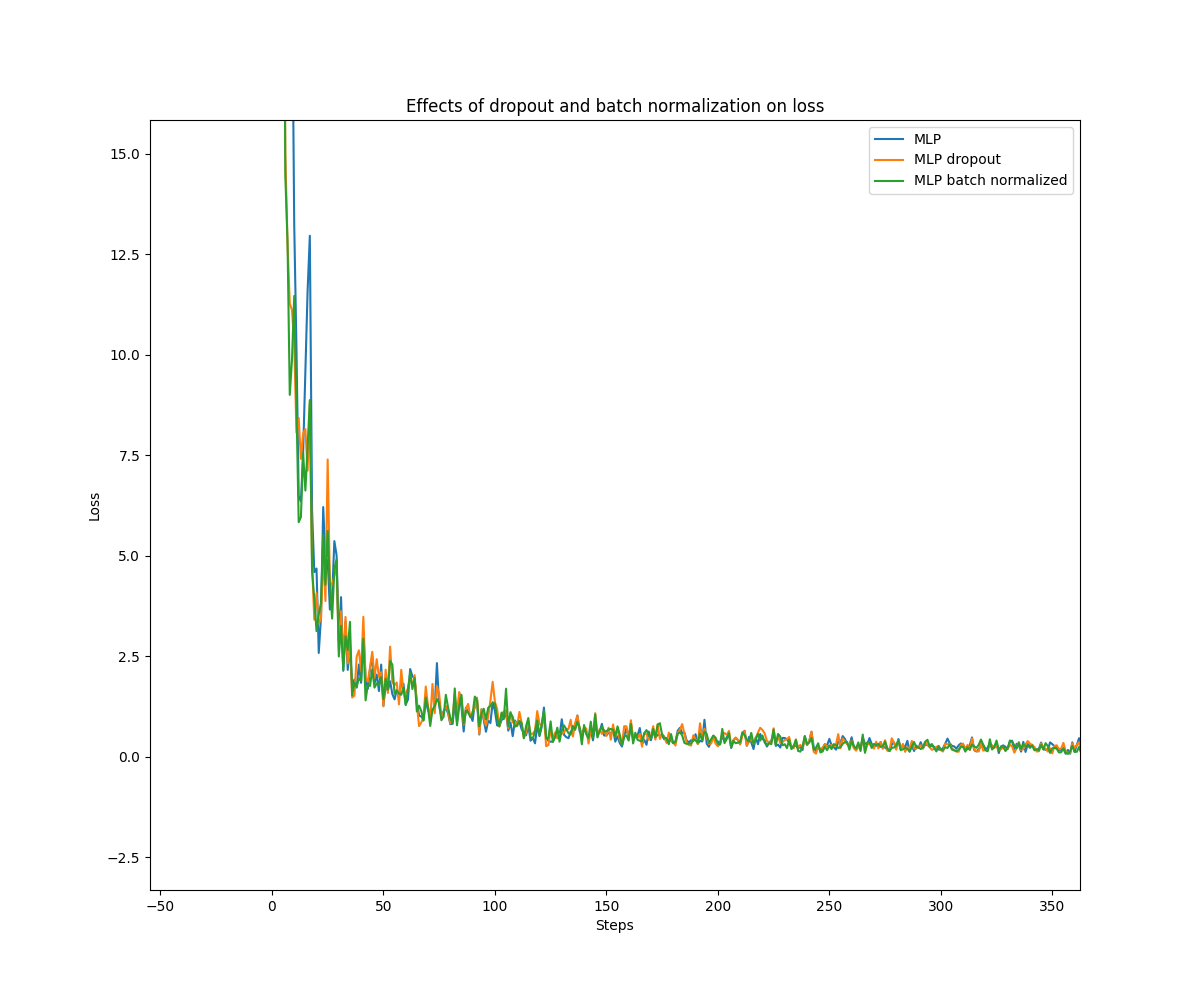

In [21]:
plt.figure(figsize=(12,10))
plt.plot(x,mlp_loss["loss"],label='MLP')
plt.plot(x,mlp_drop_loss["loss_1"],label='MLP dropout')
plt.plot(x,mlp_norm_loss["loss_2"],label='MLP batch normalized')
plt.title("Effects of dropout and batch normalization on loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 3. CNN

In [44]:
cnn_drop_acc = parse_events_file("logs/test/CNN_dropout/")
cnn_drop_loss = parse_events_file("logs/train/CNN_dropout/")
cnn_norm_acc = parse_events_file("logs/test/CNN_normalize/")
cnn_norm_loss = parse_events_file("logs/train/CNN_normalize/")

<IPython.core.display.Javascript object>


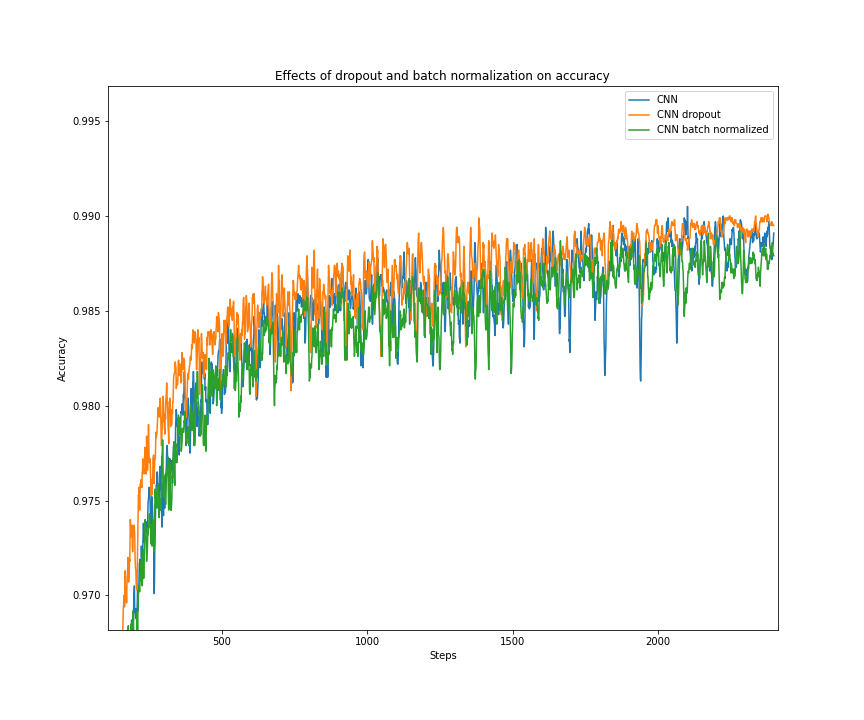

In [54]:
plt.figure(figsize=(12,10))
plt.plot(x,cnn["accuracy_6"],label='CNN')
plt.plot(x,cnn_drop_acc["accuracy_7"],label='CNN dropout')
plt.plot(x,cnn_norm_acc["accuracy_8"],label='CNN batch normalized')
plt.title("Effects of dropout and batch normalization on accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


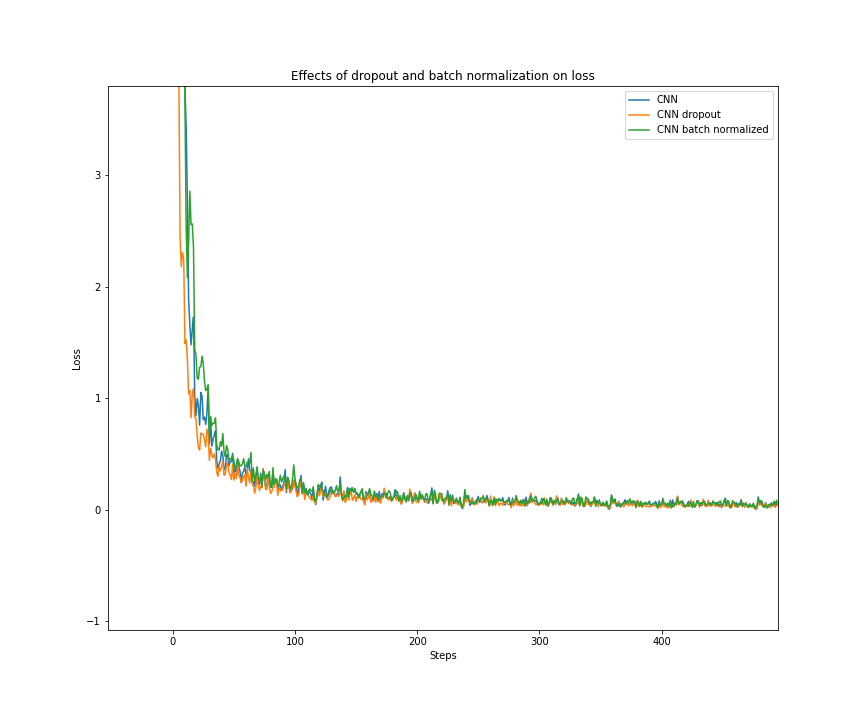

In [55]:
plt.figure(figsize=(12,10))
plt.plot(x,cnn_loss["loss_6"],label='CNN')
plt.plot(x,cnn_drop_loss["loss_7"],label='CNN dropout')
plt.plot(x,cnn_norm_loss["loss_8"],label='CNN batch normalized')
plt.title("Effects of dropout and batch normalization on loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()